자전거 대여량 예측과 연결되기 때문에 분류와 회귀 관련 문제

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from scipy import stats
import re

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 해결책
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
#print(mpl.matplotlib_fname())

train = pd.read_csv("data/train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

In [3]:
# train.columns
# train.dtypes
train.info()
# train 데이터 정보 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [4]:
train.head()
# 간략한 헤더정보
train_df = pd.DataFrame(train)
train_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [5]:
#datetime 칼럼 데이터 중 날짜 형식에 맞지 않는 데이터가 있는지 정규식을 활용하여 파악

regEx = '[0-9]{4}[-][0-9]{2}[-][0-9]{2} [0-9]{2}[:][0-9]{2}[:][0-9]{2}'


if re.search(regEx, str(train_df["datetime"])):
    print(True)
else:
    print(False)

True


In [6]:
print(train.temp.describe())

'''describe 함수로
 1. 행의 갯수 count
 2. 평균값 mean
 3. std 표준편차
 4. min 최소값
 5. 1사분위 ~ 4사분위 분포
 '''

count    10886.00000
mean        20.23086
std          7.79159
min          0.82000
25%         13.94000
50%         20.50000
75%         26.24000
max         41.00000
Name: temp, dtype: float64


'describe 함수로\n 1. 행의 갯수 count\n 2. 평균값 mean\n 3. std 표준편차\n 4. min 최소값\n 5. 1사분위 ~ 4사분위 분포\n '

In [7]:
train.isnull().sum()
# 결측치(null)가 있는지 확인 필요
# 결측치 없음

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

<AxesSubplot:>

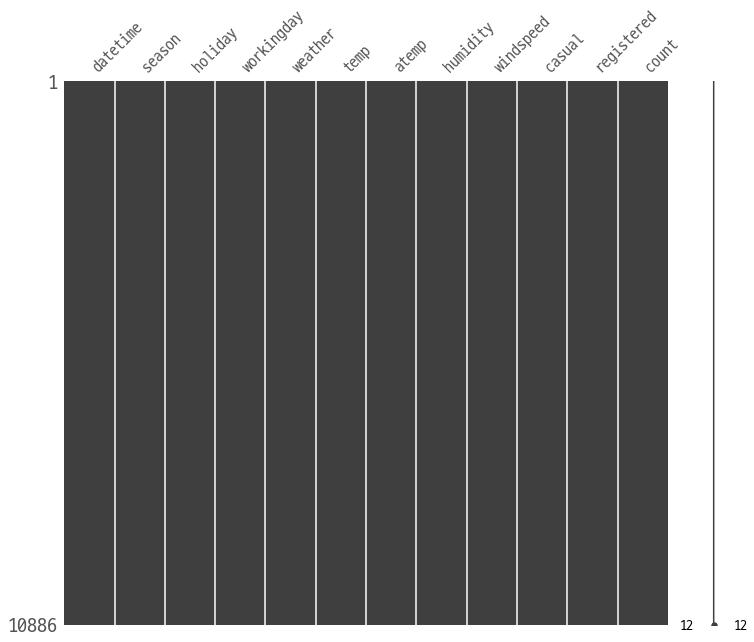

In [8]:
import missingno as msno

msno.matrix(train, figsize=(12,10))
            # 매개변수는 넓이와 높이
# 미씽노는 결측치를 시각화해서 보여줌

In [9]:
# train 데이터에 연, 월, 일, 시간, 분, 초 따로 떼어내서 각 변수로 저장
# datetime 칼럼이 datetime이었기에 가능한듯

train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train.shape



(10886, 18)

In [10]:
# matplotlib 에서 한글 깨짐 현상 발생
# 전역에서 특정 폰트 쓰는 방법
# 아나콘다 안의 matplotlib 설정 파일로 들어가(D:\anaconda\lib\site-packages\matplotlib\mpl-data\matplotlibrc)
# font-family에 원하는 폰트를 써주는 것으로 해결 가능

print(mpl.matplotlib_fname())
path = 'D:\David\D2Coding-Ver1.3.2-20180524\D2CodingLigature\D2Coding-Ver1.3.2-20180524-ligature.ttf'
f_name = fm.FontProperties(fname = path, size = 50).get_name()
print(f_name)
plt.rc('font', family = f_name)

D:\anaconda\lib\site-packages\matplotlib\mpl-data\matplotlibrc
D2Coding ligature


[Text(0.5, 1.0, '시간별 대여량')]

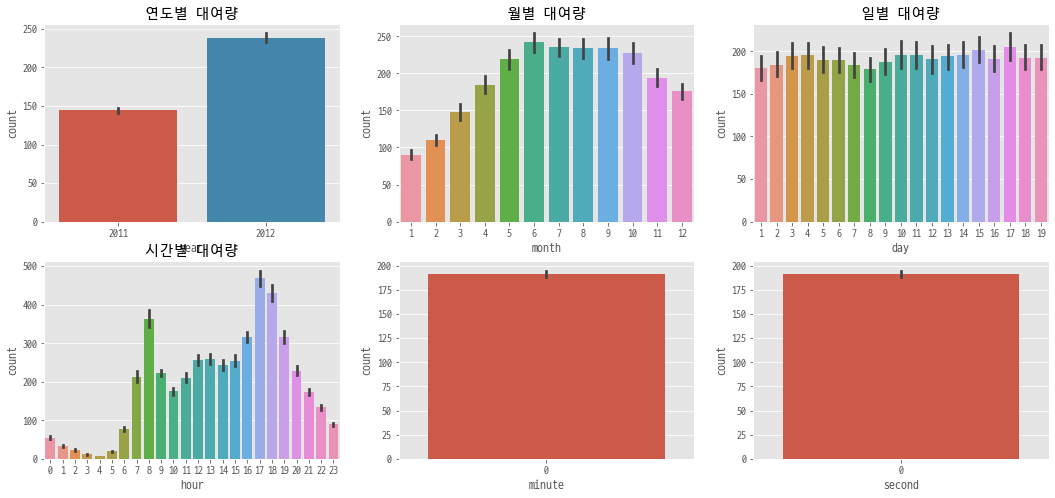

In [11]:
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
# pyplot은 기본적으로 행과 열을 축(ax)로 설정하여 전체 그래프의 배치 결정
figure.set_size_inches(18,8)
# 그래프 사이즈 설정


sns.barplot(data=train, x="year", y="count", ax=ax1)
# x 축을 연도로 하여 대여량(count) 값을 나타내는 barplot 그래프
sns.barplot(data=train, x="month", y="count", ax=ax2)
sns.barplot(data=train, x="day", y="count", ax=ax3)
sns.barplot(data=train, x="hour", y="count", ax=ax4)
sns.barplot(data=train, x="minute", y="count", ax=ax5)
sns.barplot(data=train, x="second", y="count", ax=ax6)

ax1.set(title="연도별 대여량")
# 축.set(타이틀명칭)
ax2.set(title="월별 대여량")
ax3.set(title="일별 대여량")
ax4.set(title="시간별 대여량")

### 연도 월/일/시간 변수에 따른 대여량 그래프 분석

1. 2011년에 비하여 2012년 대여량이 25%p가량 상승
2. 1월부터 대여량이 차츰 상승하여 여름에 최고치를 찍고 겨울로 바뀌는 시기부터 감소하는 추세를 보임
3. 출퇴근시간인 7시 ~ 9시와 17시 ~ 19시에 대여량이 급증
4. 밤과 새벽을 제외한 점심 전후시간대는 고른 분포를 보임

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, '근무일 여부에 따른 대여량')]

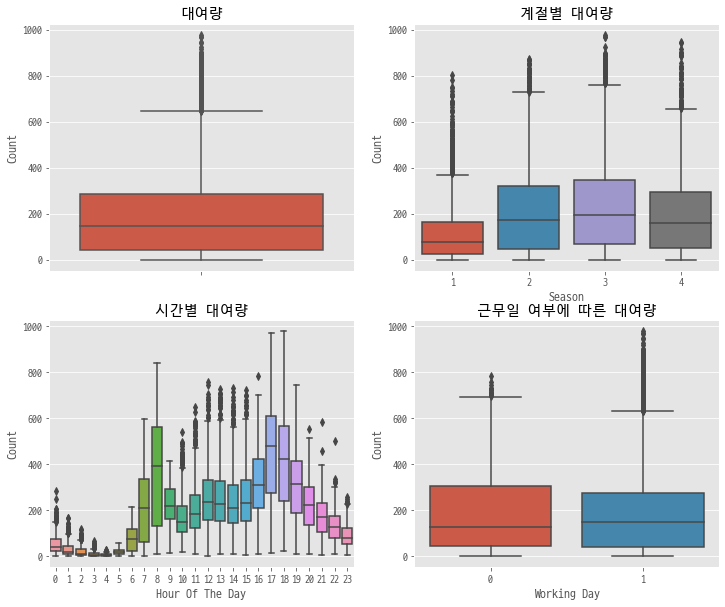

In [12]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=train,y="count",orient="v",ax=axes[0][0])
# 씨본의 박스플롯은 매개변수 안에 축(ax)를 설정하여 그래프 배치를 결정
sns.boxplot(data=train,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=train,y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=train,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="대여량")
axes[0][1].set(xlabel='Season', ylabel='Count',title="계절별 대여량")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="시간별 대여량")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="근무일 여부에 따른 대여량")

In [13]:
#대여량의 이상치 확인을 위한 함수 생성

def outlier_iqr(data, column): 

    # lower, upper 글로벌 변수 선언하기     
    global lower, upper    
    
    # 4분위수 기준 지정하기     
    q25, q75 = np.quantile(data[column], 0.25), np.quantile(data[column], 0.75)          
    
    # IQR 계산하기     
    iqr = q75 - q25    
    
    # outlier cutoff 계산하기 cutoff 기준은 1사분면과 3사분면의 1.5배 범위를 넘어서는 값들     
    cut_off = iqr * 1.5          
   
    # lower와 upper bound 값 구하기     
    lower, upper = q25 - cut_off, q75 + cut_off     
    
    print('IQR은',iqr, '이다.')     
    print('lower bound 값은', lower, '이다.')     
    print('upper bound 값은', upper, '이다.')    
    
    # 1사 분위와 4사 분위에 속해있는 데이터 각각 저장하기     
    data1 = data[data[column] > upper]     
    data2 = data[data[column] < lower]    
    print('upper 이상치 : \n',data1)
    print('lower 이상치 : \n',data2)
    # 이상치 총 개수 구하기
    return print('총 이상치 개수는', data1.shape[0] + data2.shape[0], '이다.')


outlier_iqr(train, 'count')

# print(type(train))
# print(type(train['season']))
# print(type(train_sns))
# print(type(train_sns['fare']))

IQR은 242.0 이다.
lower bound 값은 -321.0 이다.
upper bound 값은 647.0 이다.
upper 이상치 : 
                  datetime  season  holiday  workingday  weather   temp  \
6611  2012-03-12 18:00:00       1        0           1        2  24.60   
6634  2012-03-13 17:00:00       1        0           1        1  28.70   
6635  2012-03-13 18:00:00       1        0           1        1  28.70   
6649  2012-03-14 08:00:00       1        0           1        1  18.04   
6658  2012-03-14 17:00:00       1        0           1        1  28.70   
...                   ...     ...      ...         ...      ...    ...   
10678 2012-12-11 08:00:00       4        0           1        2  13.94   
10702 2012-12-12 08:00:00       4        0           1        2  10.66   
10726 2012-12-13 08:00:00       4        0           1        1   9.84   
10846 2012-12-18 08:00:00       4        0           1        1  15.58   
10870 2012-12-19 08:00:00       4        0           1        1   9.84   

        atemp  humidity  windsp

### 계절/ 주중과 주말 그래프 분석

1. 대여량이 가장 적은 계절은 봄(상식적으로 겨울이 최저일거라 생각했는데 train데이터이니 본데이터를 통한 검증이 필요)  
여름, 가을, 겨울, 봄 순으로 높음
2. 대여량은 주말에 다소 높은 경향

In [14]:
train["dayofweek"] = train["datetime"].dt.dayofweek
# 칼럼에 요일정보를 하나더 추가하여 19개 칼럼으로 바뀜
train.shape

(10886, 19)

In [15]:
train["dayofweek"].value_counts()

5    1584
6    1579
3    1553
0    1551
2    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

<AxesSubplot:xlabel='hour', ylabel='count'>

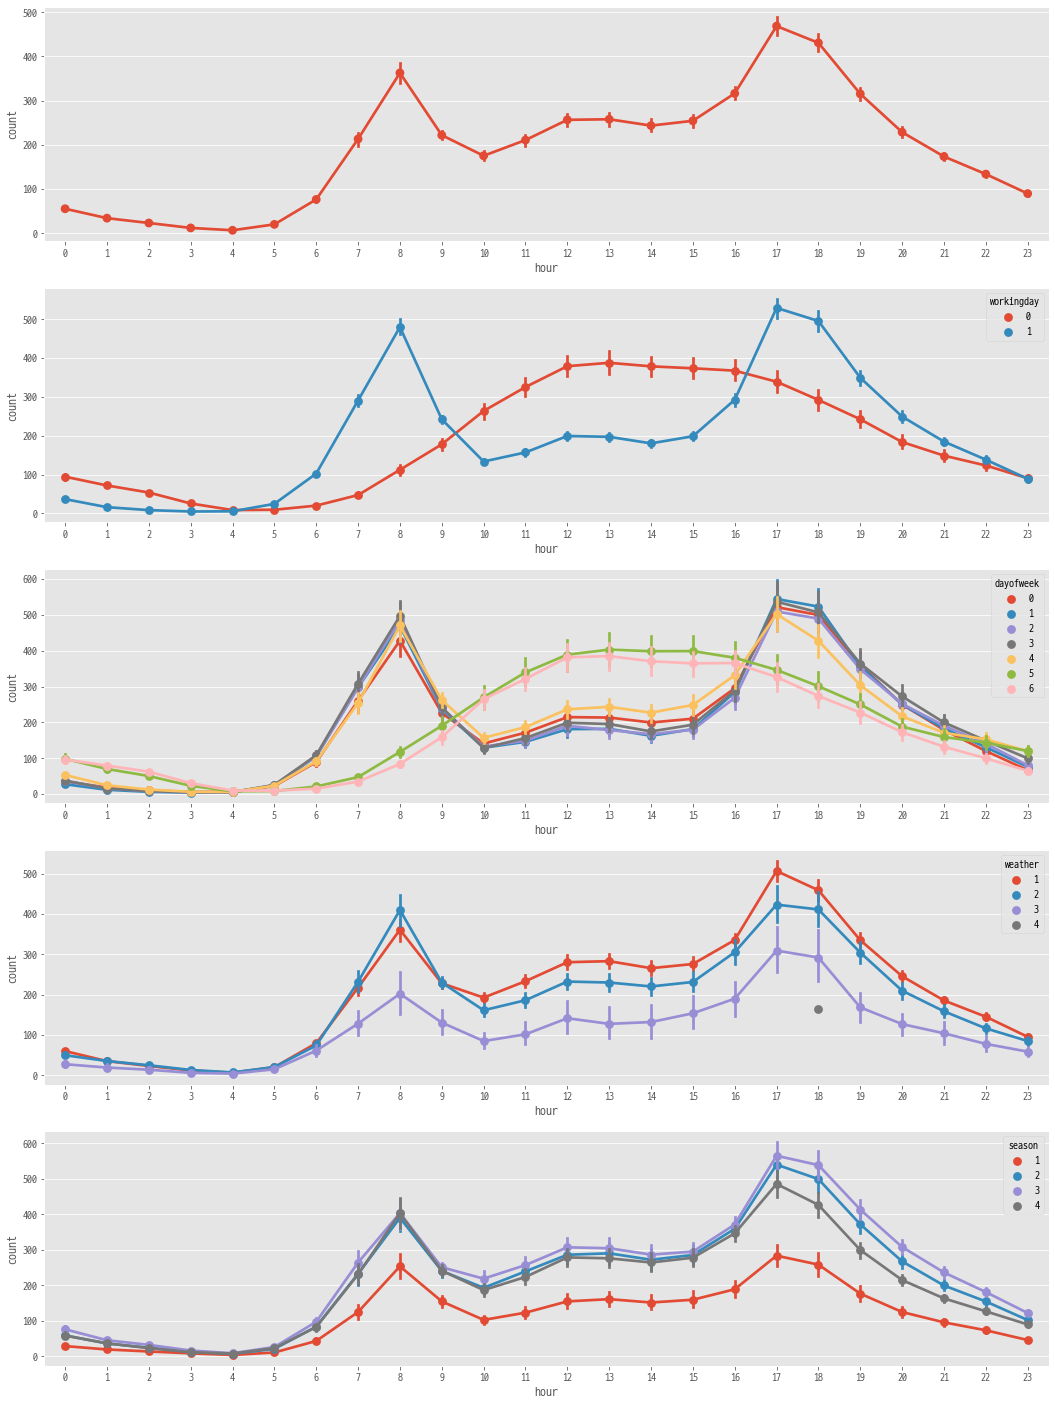

In [16]:
fig,(ax1,ax2,ax3,ax4,ax5)= plt.subplots(nrows=5)
fig.set_size_inches(18,25)

sns.pointplot(data=train, x="hour", y="count", ax=ax1)

sns.pointplot(data=train, x="hour", y="count", hue="workingday", ax=ax2)

sns.pointplot(data=train, x="hour", y="count", hue="dayofweek", ax=ax3)

sns.pointplot(data=train, x="hour", y="count", hue="weather", ax=ax4)

sns.pointplot(data=train, x="hour", y="count", hue="season", ax=ax5)

In [17]:
#상관관계 분석
corrMatt = train[["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"]]
corrMatt = corrMatt.corr()
print(corrMatt)

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

                temp     atemp    casual  registered  humidity  windspeed  \
temp        1.000000  0.984948  0.467097    0.318571 -0.064949  -0.017852   
atemp       0.984948  1.000000  0.462067    0.314635 -0.043536  -0.057473   
casual      0.467097  0.462067  1.000000    0.497250 -0.348187   0.092276   
registered  0.318571  0.314635  0.497250    1.000000 -0.265458   0.091052   
humidity   -0.064949 -0.043536 -0.348187   -0.265458  1.000000  -0.318607   
windspeed  -0.017852 -0.057473  0.092276    0.091052 -0.318607   1.000000   
count       0.394454  0.389784  0.690414    0.970948 -0.317371   0.101369   

               count  
temp        0.394454  
atemp       0.389784  
casual      0.690414  
registered  0.970948  
humidity   -0.317371  
windspeed   0.101369  
count       1.000000  


<AxesSubplot:>

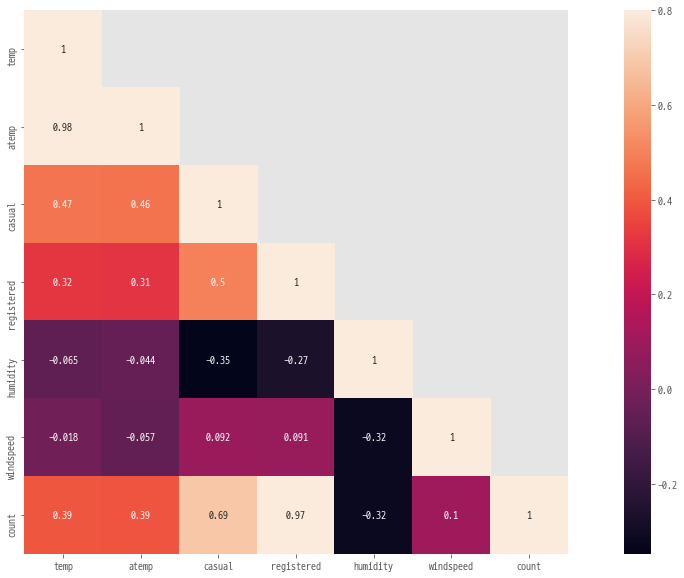

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

1. temp(기온)과 atemp(체감기온) 간 상관성은 의미 없을것으로 보이고
2. 대여량에 큰 영향을 미치는 feature는 등록여부(casual, registered)이며 기온이 그 다음 순위

<AxesSubplot:xlabel='humidity', ylabel='count'>

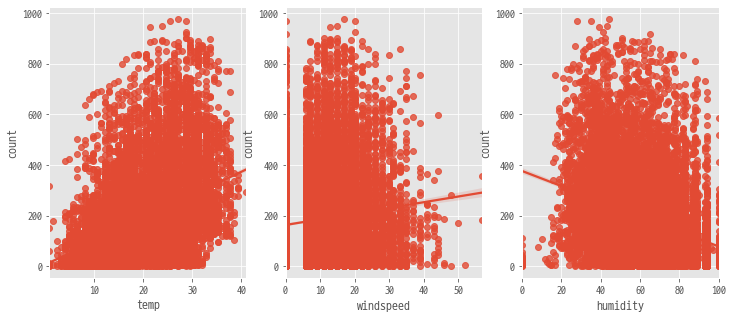

In [19]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="temp", y="count", data=train,ax=ax1)
sns.regplot(x="windspeed", y="count", data=train,ax=ax2)
sns.regplot(x="humidity", y="count", data=train,ax=ax3)

In [20]:
# 연도와 월을 이어주는 함수를 만들어서 연도+월별 대여량 추세를 확인할 예정
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month)

train["year_month"] = train["datetime"].apply(concatenate_year_month)

print(train.shape)
train[["datetime", "year_month"]].head()

(10886, 20)


,datetime,year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


<AxesSubplot:xlabel='year_month', ylabel='count'>

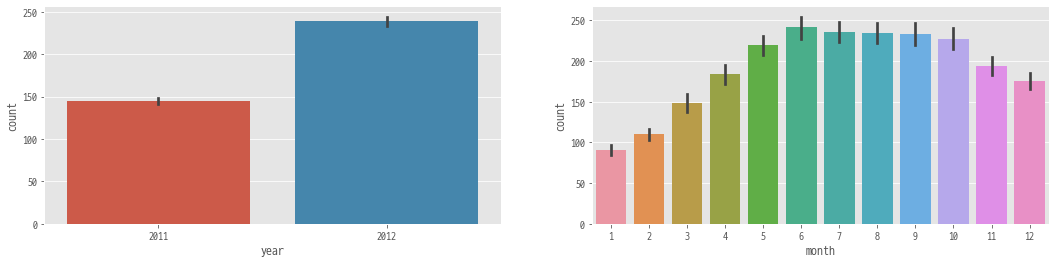

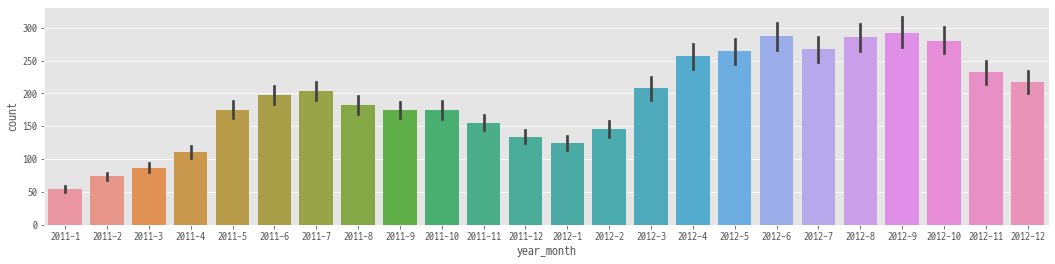

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18, 4)

sns.barplot(data=train, x="year", y="count", ax=ax1)
sns.barplot(data=train, x="month", y="count", ax=ax2)

fig, ax3 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(18, 4)

sns.barplot(data=train, x="year_month", y="count", ax=ax3)

### 2011년 1월부터 2012년 12월까지 월별 대여량 그래프 분석

11년과 12년도 그래프는 비슷한 모양을 가짐(대여량은 증가했지만 월별 증감추세는 연도마다 비슷)

In [22]:
# 이상치제거 case 1

# trainWithoutOutliers
trainWithoutOutliers = train[np.abs(train["count"] - train["count"].mean()) <= (3*train["count"].std())]
# 정상적인 데이터 수치에서 최소값, 최대값을 합한 수치의 절대값을 표준편차 3배 수준으로 이상치 제거

print(train.shape)
print(trainWithoutOutliers.shape)

(10886, 20)
(10739, 20)


D:\anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229776, 4.562423868087808, 0.9581176780909614))

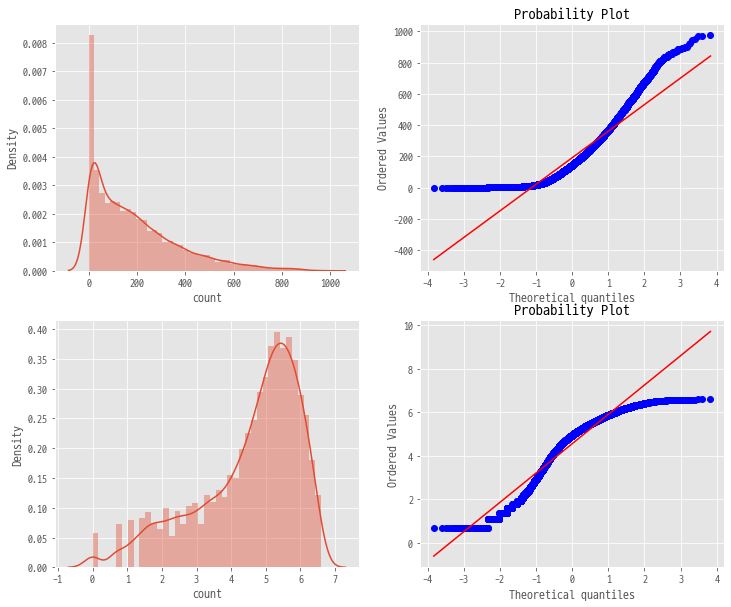

In [23]:
# 이상치가 제거된 count값의 데이터 분포도를 파악

figure, axes = plt.subplots(ncols=2, nrows=2)
figure.set_size_inches(12, 10)

sns.distplot(train["count"], ax=axes[0][0])
stats.probplot(train["count"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(trainWithoutOutliers["count"]), ax=axes[1][0])
stats.probplot(np.log1p(trainWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

In [25]:
#이상치 제거 case 2

def get_outlier(df, column, weight):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
  quantile_25 = np.percentile(df[column].values, 25)
  quantile_75 = np.percentile(df[column].values, 75)

  IQR = quantile_75 - quantile_25
  IQR_weight = IQR*weight
  
  lowest = quantile_25 - IQR_weight
  highest = quantile_75 + IQR_weight
  
  outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
  return outlier_idx

# 함수 사용해서 이상치 값 삭제
oulier_idx = get_outlier(df=train, column= 'count', weight=1.5)
train.drop(oulier_idx, axis=0, inplace=True)

D:\anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


((array([-3.82466286, -3.60029062, -3.47714484, ...,  3.47714484,
          3.60029062,  3.82466286]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.4738907 , 6.4738907 ,
         6.4738907 ])),
 (1.3360452062579253, 4.533937141246246, 0.955994121725634))

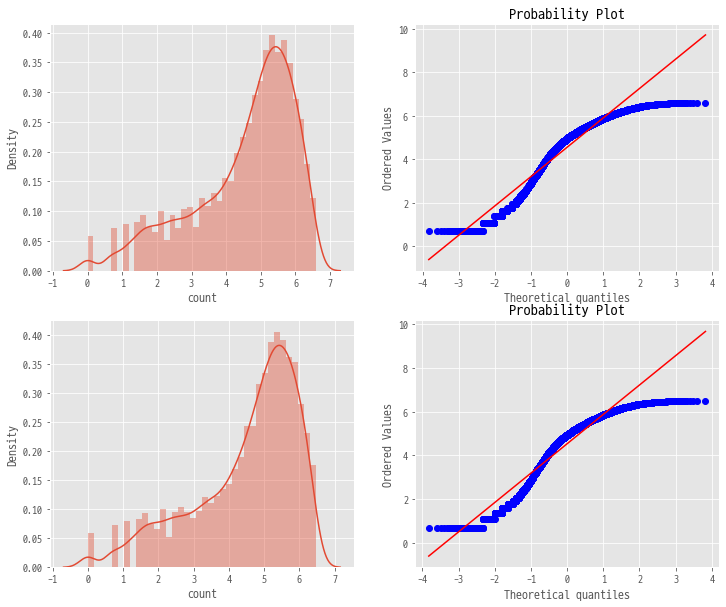

In [28]:
# 이상치제거 case2 의 count값의 데이터 분포도를 파악

figure, axes = plt.subplots(ncols=2, nrows=2)
figure.set_size_inches(12, 10)

sns.distplot(np.log(trainWithoutOutliers["count"]), ax=axes[0][0])
stats.probplot(np.log1p(trainWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(train["count"]), ax=axes[1][0])
stats.probplot(np.log1p(train["count"]), dist='norm', fit=True, plot=axes[1][1])

### 이상치 제거 전후 데이터 분포 확인

이상치 제거 방법 분석:
'case1'은 최소값과 최대값을 절대값으로 합친 후 전체 영역에서 표준편차의 3배수를 이상치로 설정하여 이상치 중 상대적으로 많은 양을 차지하는 최소값 미만의 이상치들(대부분 0으로 표기된 결측치들)이 많이 사라짐  

이와 달리 'case2'는 1사분면 경계점의 1.5배수, 3사분면 경계점의 1.5배수를 각각 이상치로 제거하였으므로 최소값과 최대값 양쪽에서 고르게 이상치가 제거됨

즉 최소값과 최대값 양쪽에서 이상치를 고르게 제거할 것인지, 전체 데이터 기준으로 이상치를 제거할 것인지에 따라 다른 결과가 나옴 

In [ ]:
# test 데이터로 머신러닝 랜덤포레스트 시작

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv("data/train.csv", parse_dates=["datetime"])
train.shape

In [ ]:
test = pd.read_csv("data/test.csv", parse_dates=["datetime"])
test.shape

In [ ]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

In [ ]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

In [ ]:
# widspeed 풍속에 대한 데이터 분포 확인
# 0 값이 가장 많으므로 데이터 보정이 필요
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count',title="test windspeed")
sns.countplot(data=test, x="windspeed", ax=axes[1])

In [ ]:
# 풍속의 0값에 특정 값을 넣어준다.
# 평균을 구해 일괄적으로 넣어줄 수도 있지만, 예측의 정확도를 높이는 데 도움이 될것 같진 않다.
# train.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()
# test.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()

In [ ]:
# 그래서 머신러닝으로 예측을 해서 풍속을 넣어주도록 한다.
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    
    # 풍속이 0인것과 아닌 것을 나누어 주고
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    # 풍속예측에 사용할 피쳐를 wCol에 담아줌
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔주고
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # 랜덤포레스트 분류 실행
    rfModel_wind = RandomForestClassifier()

    # wCol에 있는 피처의 값을 바탕으로 0이 아닌 풍속을 학습
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # 학습한 값을 바탕으로 풍속이 0인 데이터의 풍속을 예측
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # 값이 0으로 기록 된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values

    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)

    # 풍속의 데이터타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

In [ ]:
# 0값을 조정한다.
train = predict_windspeed(train)
# test = predict_windspeed(test)

# widspeed 의 0값을 조정한 데이터를 시각화
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=ax1)

풍속은 대여량과 역의 관계를 가지며 풍속 16 이후부터는 급격한 하락세를 보임

In [ ]:
# 연속형 feature와 범주형 feature 
# 연속형 feature = ["temp","humidity","windspeed","atemp"]
# 범주형 feature의 type을 category로 변경 해 준다.
#(이유는 계절이 갖는 값 1, 2, 3, 4는 계산이 되는 수치형 값이 아닌 단순 범주만을 나타낸다.)
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [ ]:
feature_names = ["season", "weather", "temp", "atemp", "humidity", "windspeed",
                 "year", "hour", "dayofweek", "holiday", "workingday"]

feature_names

In [ ]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

In [ ]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

In [ ]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

RMSLE
과대평가 된 항목보다는 과소평가 된 항목에 패널티를 준다.

오차(Error)를 제곱(Square)해서 평균(Mean)한 값의 제곱근(Root) 으로 값이 작을 수록 정밀도가 높다.

0에 가까운 값이 나올 수록 정밀도가 높은 값이다.

Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE)

$$ \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } $$
${n}$ is the number of hours in the test set
$p_i$ is your predicted count
$a_i$ is the actual count
$\log(x)$ is the natural logarithm

잔차(residual)에 대한 평균에 로그를 씌운 값이다. => 과대평가 된 항목보다 과소 평가 된 항목에 패널티를 주기위해

정답에 대한 오류를 숫자로 나타낸 값으로 값이 클수록 오차가 크다는 의미이며 값이 작을수록 오류가 적다는 의미를 나타낸다.

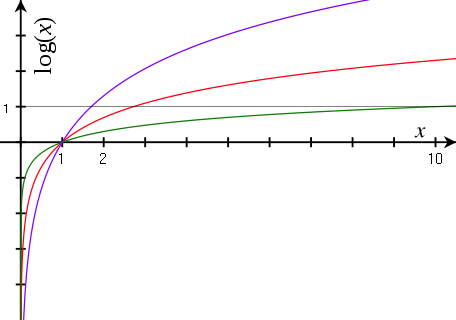
image.png이미지 출처 : 위키피디아 https://ko.wikipedia.org/wiki/로그

In [ ]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 변경
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    # 평균
    mean_difference = difference.mean()
    
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

Cross Validation 교차 검증
일반화 성능을 측정하기 위해 데이터를 여러 번 반복해서 나누고 여러 모델을 학습한다
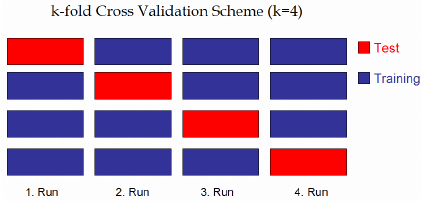
image.png이미지 출처 : https://www.researchgate.net/figure/228403467_fig2_Figure-4-k-fold-cross-validation-scheme-example  

KFold 교차검증
데이터를 폴드라 부르는 비슷한 크기의 부분집합(n_splits)으로 나누고 각각의 폴드 정확도를 측정한다.
첫 번째 폴드를 테스트 세트로 사용하고 나머지 폴드를 훈련세트로 사용하여 학습한다.
나머지 훈련세트로 만들어진 세트의 정확도를 첫 번째 폴드로 평가한다.
다음은 두 번째 폴드가 테스트 세트가 되고 나머지 폴드의 훈련세트를 두 번째 폴드로 정확도를 측정한다.
이 과정을 마지막 폴드까지 반복한다.
이렇게 훈련세트와 테스트세트로 나누는 N개의 분할마다 정확도를 측정하여 평균 값을 낸게 정확도가 된다.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# 10개의 폴드셋트로 나누고 검증 진행
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

max_depth_list = []

# n_estimators 수치가 높을수록 정확도가 높아짐(나무에 해당)
model = RandomForestRegressor(n_estimators=100,
                              n_jobs=-1,
                              random_state=0)
model

In [ ]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
# 0에 근접할수록 좋은 데이터
print("Score= {0:.5f}".format(score))

In [ ]:
# 학습시킴, 피팅 - 피처와 레이블을 통한 학습
model.fit(X_train, y_train)

In [ ]:
# 예측 실행
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

In [ ]:
# 예측한 데이터를 시각화
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test_prediction")

train 데이터와 test 데이터가 비슷한 모양을 보임

In [ ]:
submission = pd.read_csv("data/sampleSubmission.csv")
submission

submission["count"] = predictions

print(submission.shape)
submission.head()

In [ ]:
submission.to_csv("data/Score_{0:.5f}_submission.csv".format(score), index=False)